# Unsupervised Learning Predict - Movie Recommender System
© Explore Data Science Academy

---
*   Thomas Kenyon
*   Name
*   Name
*   Name
*   Name
---

### Honour Code

We, Team 8, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

---

### Predict Overview: Movie Recommender

--Insert description and context here

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering & Content-based Recommender</a>

<a href=#five>5. Modeling</a>

<a href=#eight>8. Appendix</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---

In [28]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud, STOPWORDS

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
import tqdm as tq

In [4]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---

In [2]:
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
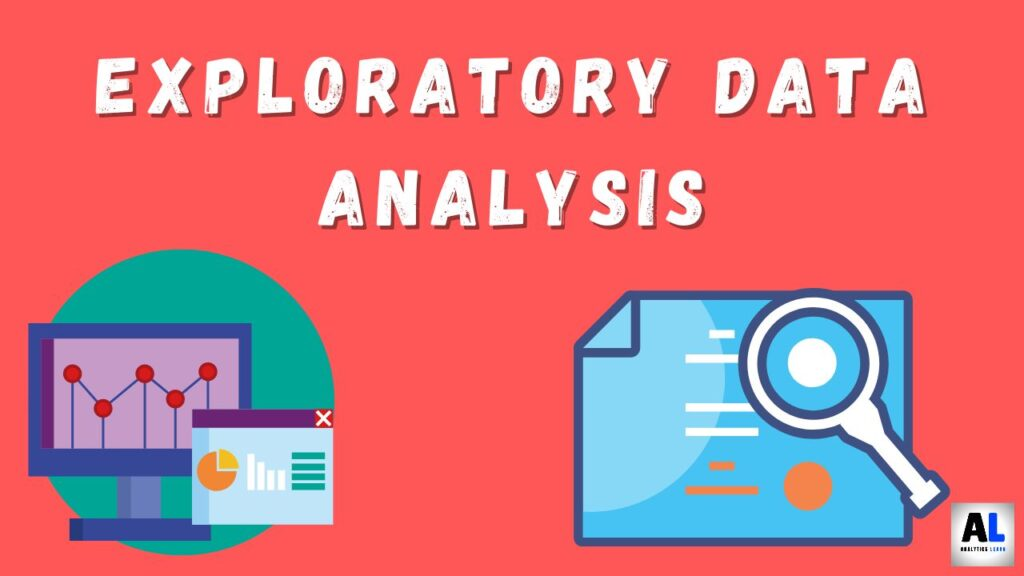

In [3]:
genome_scores.isnull().sum()
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [4]:
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [5]:
imdb_data.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [6]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [7]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
test.isnull().sum()

Unnamed: 0           0
movieId              0
title                0
genres               0
title_cast       47453
director         47076
runtime              0
budget               0
plot_keywords    48181
soup                 0
year                 0
dtype: int64

In [10]:
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [13]:
joined_table = train.merge(movies, how='left', on='movieId')

In [14]:
joined_table.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [17]:
joined_table2 = joined_table.merge(imdb_data, how='left', on='movieId')
joined_table2.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [18]:
movie_genre = pd.DataFrame(joined_table2[['movieId', 'genres']], columns=['movieId', 'genres'])
movie_genre['genres'] = movie_genre['genres'].apply(lambda x: x.split('|'))

movie_genre = pd.DataFrame([(tup.movieId, d) for tup in movie_genre.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movie_genre.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


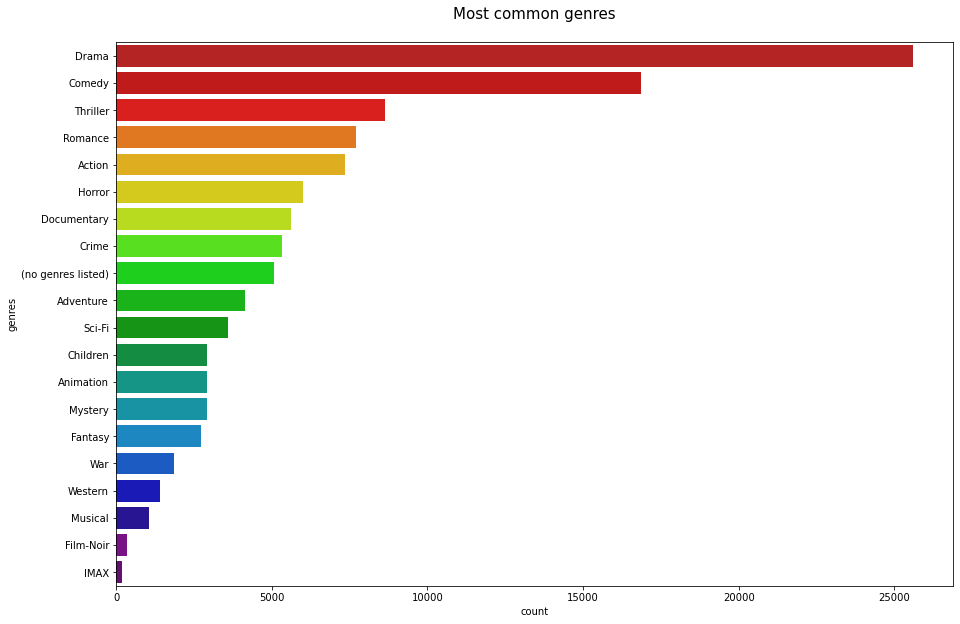

In [19]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=15)
sns.countplot(y="genres", data=movie_genre,
              order=movie_genre['genres'].value_counts(ascending=False).index,
              palette="nipy_spectral_r")
plt.show()

In [25]:
joined2 = movies.merge(imdb_data,  how='left', on = 'movieId')

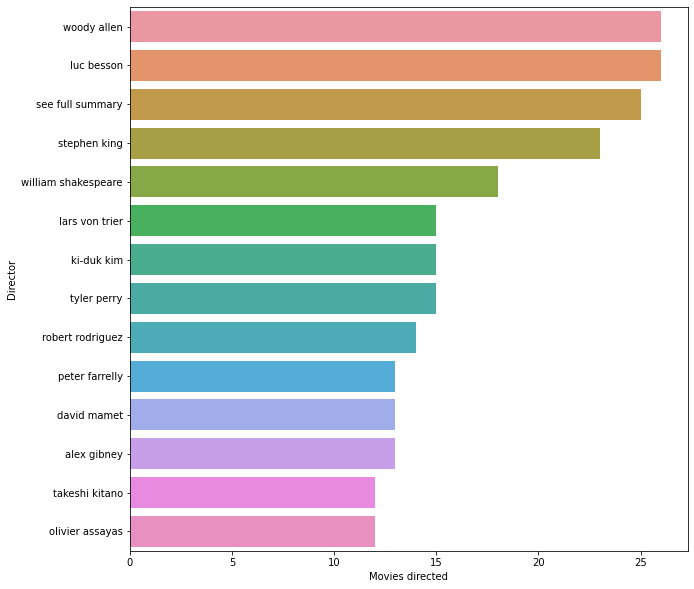

In [31]:
joined2['director'] = joined2['director'].str.lower()
joined2['director'] = joined2['director'].astype(str)
directors = '|'.join([text for text in joined2['director']])

plt.rcParams['figure.figsize'] = [10, 10]
freq_dist = nltk.FreqDist(directors.split('|'))
df = pd.DataFrame({'Director': list(freq_dist.keys()),
                  'Movies directed' : list(freq_dist.values())})

df = df.nlargest(columns='Movies directed', n=15).iloc[1:]

ax = sns.barplot(data=df, y='Director', x='Movies directed')
plt.show()

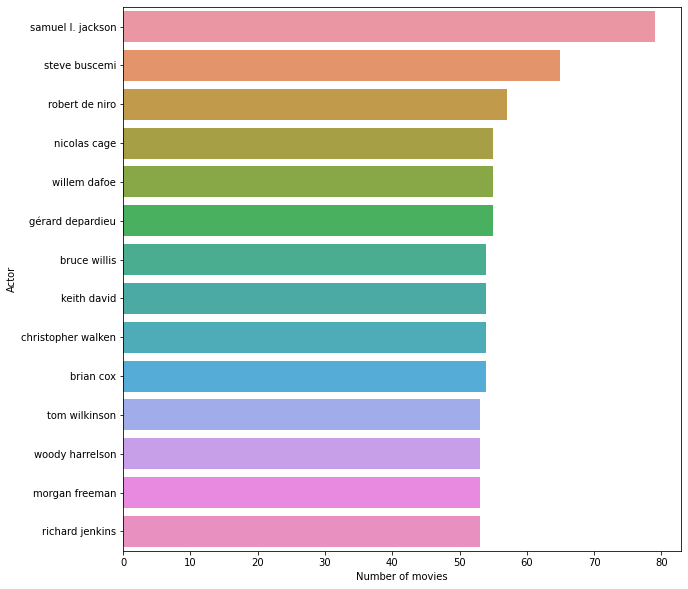

In [30]:
joined2['title_cast'] = joined2['title_cast'].str.lower()
joined2['title_cast'] = joined2['title_cast'].astype(str)
cast = '|'.join([text for text in joined2['title_cast']])

plt.rcParams['figure.figsize'] = [10, 10]
# plt.subplot(1, 4, i + 1)
freq_dist = nltk.FreqDist(cast.split('|'))
df = pd.DataFrame({'Actor': list(freq_dist.keys()),
                  'Number of movies' : list(freq_dist.values())})

df = df.nlargest(columns='Number of movies', n=15).iloc[1:]

ax = sns.barplot(data=df, y='Actor', x='Number of movies')
plt.show()

lol why are there so many PG16/18 words in tihis WordCloud

(-0.5, 599.5, 399.5, -0.5)

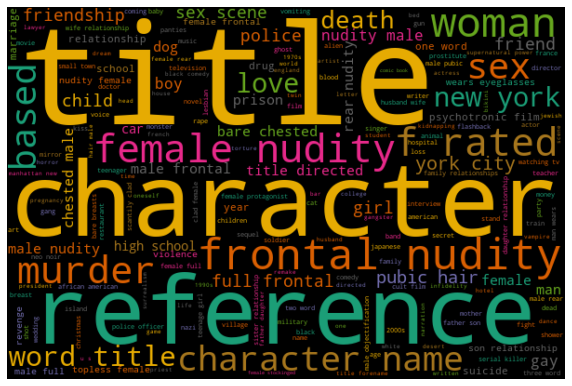

In [32]:
joined2['plot_keywords'] = joined2['plot_keywords'].str.lower()
joined2['plot_keywords'] = joined2['plot_keywords'].astype(str)
genres = '|'.join([text for text in joined2['plot_keywords'] if not text == 'nan'])

wc = WordCloud(width=600, height=400, 
               background_color='black', colormap='Dark2',
               max_font_size=150, random_state=42)
wc.generate(genres)
# plt.subplot(2, 2, i + 1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.title(full_title[i])

<AxesSubplot:>

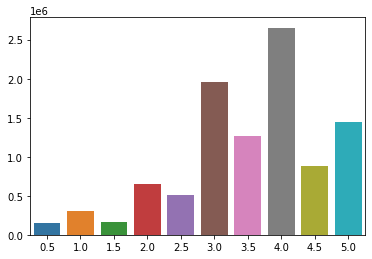

In [20]:
ratings=train['rating'].value_counts()

sns.barplot(ratings.index, ratings.values)

In [22]:
joined_table2 = joined_table.merge(imdb_data, how='left', on='movieId')
joined_table2.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...


<AxesSubplot:ylabel='Frequency'>

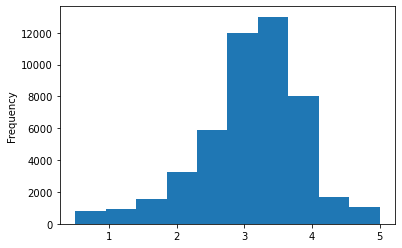

In [23]:
rankings = joined_table2[['rating','title']].groupby('title').mean().sort_values('rating', ascending=False)
rankings ['num_ratings']= joined_table2.groupby('title')['rating'].count()
new = rankings.sort_values(by=['num_ratings', 'rating'], ascending=False).head()
norm = train.groupby('movieId')['rating'].mean()

norm.plot(kind='hist')

<AxesSubplot:xlabel='rating', ylabel='num_ratings'>

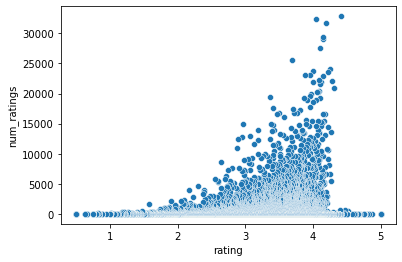

In [24]:
sns.scatterplot(data=rankings, x='rating', y='num_ratings')

<a id="four"></a>
## 4. Data Engineering & Content-based Recommender
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---

Prior to training a model with any sort of data, it is essential to re-engineer it. This is to ensure that the data is in a consistent form with no missing values, incorrect data types or just plain incorrect data. For structured,  numeric data, this entails scaling values, filling in missing values and typecasting any non-numeric data to numeric form. Non-numeric data, such as this database is often unstructured and consists of text data. This type of data is not easily interpretable by computers. Computers work with 1s and 0s, not letters and words. Therefore it must be converted into a form that is interpretable, and therefore, numeric data. 

---
First thing, we need to merge the movies dataframe with the imdb_data dataframe, these two dataframes contain most of the information we need to construct our recommender.

As you can see, for each movie we now have multiple columns that contain useful information about each movie:
* genres
* title_cast
* director
* plot_keywords

There are more columns that could be useful, such as budget, but lets stick to these for now.

In [ ]:
joined2 = movies.merge(imdb_data,  how='left', on = 'movieId')
joined2.head()

There is a lot of actors names for each movie in the title_cast column! Since we're going to ultimately be vectorizing all of this data, we should ask ourselves if we really need all the actors for each movie listed in this column. For the sake of minimizing the number of features in our vectorized dataset, lets reduce this to the top 3 actors. The first 3 actors in this column seem to be the top-billed/most prominent cast for each film, so it's likely that they're the most important anyway.

In [ ]:
def first_3(actors):
  s = []
  s = [actor for actor in actors if len(s) < 3]
  s2 = s[:3]
  return '|'.join([actor for actor in s2])

# x = ['Rhys Ifans', 'Tim Allen', 'Don Rickles', 'Crispin Glover', 'Christian McKay']
# print(first_3(x))


joined2['title_cast'] = joined2['title_cast'].apply(lambda x: str(x).split('|'))
joined2['title_cast'] = joined2['title_cast'].apply(first_3)
joined2.head(2)

One problem with this dataset are the number of nan values. Most of these are actual np.nan null values, however some of them are actually 'nan' strings. Sneaky! We'll need to convert all these cryptic nan values to real nan values and then imput something whenever they occur, since null values cannot be passed to a vectorizer.

In [ ]:
def check_nan(field):
  '''Some NaN values are being stored as strings, so fillna wont work'''
  if not isinstance(field, str):
    return np.nan
  f2 = field.strip().lower()
  if 'nan' in f2:
    return np.nan
  else:
    return field

joined3 = joined2.copy()
joined3['title_cast'] = joined3['title_cast'].apply(check_nan)
joined3['plot_keywords'] = joined3['plot_keywords'].apply(check_nan)

Lets replace all nan values with empty strings. This means that there will be a lot of movies with a lot of empty metadata columns, but hopefully when we include the genome tag dataset this will become less of an issue.

In [ ]:
joined3['director'].fillna('', inplace = True)
joined3['title_cast'].fillna('', inplace = True)
joined3['runtime'].fillna(0, inplace = True)
joined3['budget'].fillna(0, inplace = True)
joined3['plot_keywords'].fillna('', inplace = True)

Creating a word soup column. This column has all the text data in it that we will vectorize. Think of all the words/names in these columns becoming tags. I've added director 3 times so that it has more weighting. IE, if someone likes a movie like Inception, then they are likely to enjoy other movies directer by Christopher Nolan. This is quite a janky way of altering the weightings of specific tags, but creating a word soup like this does simplify the vectorizing process.

In [ ]:
joined3['soup'] = joined3['genres'] + '|' + joined3['director'] + '|' + joined3['director'] + '|' + joined3['director'] + '|' + joined3['plot_keywords'] + '|'+ joined3['title_cast']
joined3.iloc[1]

The movie titles contain their release year. We'll leave those in to keep things compatible with the streamlit app. But we'll also add the years to their own column. Just in case we decide to use this information

In [ ]:
def get_year(title):
  s = title.split()
  year = s[-1]
  if '(' in year and ')' in year:
    year2 = year[1:-1]
    return year2
  else:
    return np.nan
  
joined3['year'] = joined3['title'].apply(get_year)

Filling in nan values in the year column with 0 

In [ ]:
joined3['year'].fillna('0', inplace = True)

#### What to do about the genome tag data?

---
The genome tag data consists of 1128 tags assigned to the movies in the movie database. What is handy about this data is that there are no null values. 1128 standardized tags used across all movies is also useful for the purposes of vectorization, at most, we'll only be adding 1128 new features. This is very efficient considering how much data there is! One other thing, each tag for each movie is assigned a relevance value. Values closer to zero mean that particular tag is not related to that movie, a relevance closer to 1 means that a tag is related to a movie.

---
How would we add these tags to our word soup data while also accounting for the extra data contained in the relevance column? The option we've gone for here is again quite janky, tags with a relevance >= 0.5 will be added to a particular movie's word soup once, while tags with a relevance >= 0.8 will be added twice, thus increasing their weighting in the same way adding the director of a movie multiple times to its word soup increases weighting.

---
Word of warning, we could not find a straightforward way to write this code more efficiently, on a relatively new laptop with an 11th gen i5 processer the cell below takes 2h30m to run. Fortunately, it only needs to be run once.

Use the code located 3 cells below thats been commented out to import the output dataframe 

In [ ]:
%%time
def get_genome_tags(movieid):
    scores = genome_scores.loc[genome_scores['movieId'] == movieid]
    output = []
    output2 = ''
    for index, row in scores.iterrows(): # itering through a dataframe is heresy but we're taking the janky route here
        tag = genome_tags.loc[genome_tags['tagId'] == row['tagId']].values[0][1]
        relevance = row['relevance']
        if relevance >= 0.5:
            output += [tag]
        if relevance >= 0.80:
            output += [tag]
        output2 = '|'.join([x for x in output])
        #print(output2)
    return output2


# joined3['genome'] = joined3['movieId'].apply(get_genome_tags)
joined4 = joined3.copy()
# joined4
joined4['genome'] = joined4['movieId'].apply(get_genome_tags)
joined4.head()

In [ ]:
joined4['soup'] = joined4['soup'] + '|' + joined4['genome']

In [ ]:
joined4.drop('genome', inplace=True, axis=1)

Uncomment and run this cell below to load the output dataframe from code 3 cells above:

In [ ]:
# joined4 = pd.read_csv('joined_df_soup_genome3.csv')

In [ ]:
joined4['soup'][3]

Great! That looks like a pretty decent collection of tags

#### Time to vectorize
We've got a soup column that now contains all the movie information we want. It's time to vectorize! One thing to note, we'll need to be careful to ensure that the vectorizer splits our word soup into the correct 'tokens'. We don't want tokens to be generate at each whitespace, Morgan Freeman is one person (or God?) so we don't want our vectorizer to split his name into two tokens. We'll avoid this by using a special regex pattern that'll split tokens when it encounters the '|' symbol, since that is what we've been using to seperate our terms in our word soup.

In [ ]:
tf = TfidfVectorizer(analyzer='word',
                     min_df=4, max_df=0.5, max_features=100000, token_pattern='[A-Za-z .]{3,50}')

In [ ]:
tf_soup = tf.fit_transform(joined4['soup'])

In [ ]:
tf_soup

This vectorized object is a sparse matrix, if we wanted to use as little memory as possible we'd keep it sparse, but for simplicity's sake we're going to convert it to a dense array and then to a dataframe so we can use the movie titles as the dataframe's index. This will definitely use far more memory, but it'll make our code easier to read.

In [ ]:
tfidf_df = pd.DataFrame(tf_soup.toarray(),  columns=tf.get_feature_names())

In [ ]:
tfidf_df.index = joined4['title']

In [ ]:
tfidf_df.shape

A few movies in this dataset are actually duplicated, lets remove those duplicates now before attempting PCA or any cosine similarity calculations.

In [ ]:
tfidf_df = tfidf_df[~tfidf_df.index.duplicated(keep='first')]

In [ ]:
tfidf_df.shape

In [ ]:
tfidf_df.head()

### PCA time

---
Okay, so we've got an enormous dataframe with 62325 rows and 6526 columns (features). That is a huge dataframe! Not just to store and manipulate but also to perform calculations on. It's likely that many of these features are not that important, ie, they don't contain much information about each observation and don't explain much of the variation in the dataset. We'll use Principal Component analysis here to reduce the number of features in our dataset while having a minimal effect on the the quality of the dataset.

---
Another reason we converted our vectorized soup data to a dataframe is that Sklearn's PCA implementation doesn't support sparse matrices as input!

DO NOT run the cell below. IT takes ~12 minutes to run and uses about 13GB of memory. The image below is it's output and has been saved from a previous run and added here for convenience purposes.

In [ ]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(tfidf_df)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)

# plot line graph of cumulative variance explained 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://github.com/ethanmacrae/unsupervised-predict-streamlit-template/blob/master/resources/imgs/Cumulative_explained_variance.png?raw=true")

Amazing! From the graph above, we can see that the majority of variation between observations can be explained by a fraction of the features. It appears that if we were to keep the 1000 most significant principal components we'd still be able to explain ~90% of the variation. Not only will that significantly reduce the memory footprint of our dataset, it'll also drastically speed up movie prediction times.

---
Lets now confirm that the first 1000 principal components really do explain most of the variance and then store them in a numpy array

In [ ]:
# create PCA object with n_components set to 1000
pca_reg = PCA(n_components=1000)

# fit the PCA model to our data and apply the dimensionality reduction 
PCA_array = pca_reg.fit_transform(tfidf_df)

# confirm the number of components
pca_reg.n_components_



pca_reg.explained_variance_ratio_.sum()

Storing the PCA data as a numpy array proved to be the most efficient (better than a dataframe). This .npy file is what is loaded into streamlit and used to make content-based recommendations

---
Since this data doesn't contain movie titles, we're also going to save a dataframe containing just the movie titles as a separate csv file.

In [ ]:
from numpy import asarray
from numpy import save
save('PCA1000features.npy', PCA_array)

In [ ]:
titles_df = tfidf_df.index
titles_df = pd.DataFrame(titles_df.values, columns=['title'])
titles_df.to_csv('titles_df.csv')

Assuming you haven't run the the PCA code above for obvious reasons, you can run the cell below to load the two files that were saved in the two cells above. Then we'll assign the movie titles as indexes in the PCA dataframe.

In [ ]:
from numpy import load
# load array
PCA_array = load('PCA1000features.npy')
titles = pd.read_csv('titles_df.csv')

In [ ]:
PCA_df = pd.DataFrame(PCA_array)

In [ ]:
PCA_df.index = titles['title']

In [ ]:
PCA_df.head()

Below is our function to generate contant-based recommendations

In [ ]:
%%time
def content_model(movie_list,top_n=10):
    recommended_movies = []
    sims1 = cosine_similarity(PCA_df.loc[movie_list[0]].values.reshape(1, -1), PCA_df)
    sims2 = cosine_similarity(PCA_df.loc[movie_list[1]].values.reshape(1, -1), PCA_df)
    sims3 = cosine_similarity(PCA_df.loc[movie_list[2]].values.reshape(1, -1), PCA_df)
    sims1_df = pd.DataFrame(sims1.T, index=PCA_df.index,columns=['similarity_score'])
    sims2_df = pd.DataFrame(sims2.T, index=PCA_df.index,columns=['similarity_score'])
    sims3_df = pd.DataFrame(sims3.T, index=PCA_df.index,columns=['similarity_score'])
    del sims1,sims2,sims3
    sims1_df.drop(movie_list[0], inplace=True)
    sims2_df.drop(movie_list[1], inplace=True)
    sims3_df.drop(movie_list[2], inplace=True)
    sims1_df_sorted = sims1_df.sort_values(by='similarity_score', ascending=False)
    sims2_df_sorted = sims2_df.sort_values(by='similarity_score', ascending=False)
    sims3_df_sorted = sims3_df.sort_values(by='similarity_score', ascending=False)
    del sims1_df,sims2_df,sims3_df
    sims1_df_sorted = sims1_df_sorted.head(100)
    sims2_df_sorted = sims2_df_sorted.head(100)
    sims3_df_sorted = sims3_df_sorted.head(100)
    final = sims1_df_sorted.append([sims2_df_sorted, sims3_df_sorted])
    final = final[~final.index.duplicated(keep='first')]
    final.sort_values(by='similarity_score', ascending=False, inplace=True)
    recommended_movies = final.head(top_n).index
    return recommended_movies
    
print(content_model(['Moana (2016)', 'Toy Story (1995)', 'Ice Age (2002)']))